In [2]:
import tensorflow

In [3]:
tensorflow.__version__

'2.15.0'

### MNIST DIGITS GENERATION USING GAN

#### PIPELINE
Steps involved
1. Import libraries
2. Data Loading and Visualisation
3. Data Preprocessing
4. Model Building
5. Model Training
6. Generating a GIF of Generated Images

#### IMPORTING LIBRARIES

In [4]:
# importing necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import imageio
from IPython import display
from skimage.transform import resize
import numpy as np
import os

### Data Loading and Visualization

In [5]:
## Load the MNIST data
(train_images,train_labels),(_,_)=tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


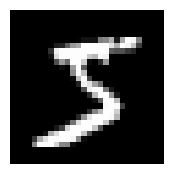

Label:5
(28, 28)


In [6]:
## Visualize a sample image
plt.figure(figsize=(2,2))
plt.imshow(train_images[0],cmap='gray')
plt.axis('off')
plt.show()
print(f"Label:{train_labels[0]}")
print(train_images[0].shape)

### DATA PREPROCESSING
1. Normalization of Images
2. Resize Images
3. Reshape Images
4. Shuffle Data

### Declare Buffer Size, Batch Size and Dimensions of Noise

In [7]:
BUFFER_SIZE=60000
BATCH_SIZE=2048
NOISE_DIM = 100

#### Normalization of Images between [-1,1]
Pixel Normalization with zero center

In [8]:
# Normalize the images to [-1.0,1.0]
train_dataset = (train_images/127.5)-1.0

#### Resize Images to size(32,32)

In [9]:
train_images = np.zeros((BUFFER_SIZE,32,32))
for index,img in enumerate(train_dataset):
    train_images[index,:,:] = resize(img,(32,32))

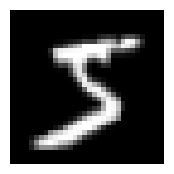

Label:5
(32, 32)


In [10]:
## Visualize a sample image
plt.figure(figsize=(2,2))
plt.imshow(train_images[0],cmap='gray')
plt.axis('off')
plt.show()
print(f"Label:{train_labels[0]}")
print(train_images[0].shape)

### Reshape Image to add channel dimension

In [11]:
train_images= train_images.reshape(train_images.shape[0],32,32,1).astype('float32')

### Reshape Image to add channel dimension

In [12]:
train_images.shape

(60000, 32, 32, 1)

#### Shuffle the data and store in Batches

In [13]:
## batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE,seed=42).batch(BATCH_SIZE)

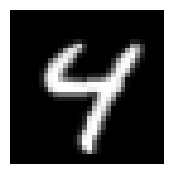

In [14]:
sample = next(iter(train_dataset))
plt.figure(figsize=(2,2))
plt.imshow(sample[0].numpy()[:,:,0],cmap='gray')
plt.axis('off')
plt.show()

### MODEL BUILDING
1. Generator Model Building
2. Discriminator Model Building

#### Generator Model Building using Transposed Convolutional Layers

In [15]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4*4*128, use_bias=False, input_shape=(NOISE_DIM,))) # 1-D
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((4, 4, 128)))

    model.add(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), use_bias=False, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), use_bias=False, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), use_bias=False, padding='same', activation='tanh'))

    return model

#### Generator Image by novice Generator before Generator-Training

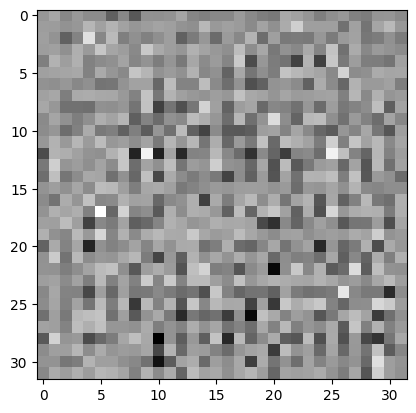

In [16]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [17]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              204800    
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147456    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 128)         5

#### Discriminator Model Building using convolutional layers

In [18]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), use_bias=False,
                                     input_shape=[32, 32, 1]))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(1, (10, 10), strides=(1, 1)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model

In [19]:
discriminator = make_discriminator_model()
print(discriminator.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        144       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 30, 30, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4608      
                                                                 
 batch_normalization_3 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        18432     
                                                      

In [20]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.0012785]], shape=(1, 1), dtype=float32)


### Model Training
1. Loss Type
2. Discriminator Loss
3. Generator Loss
4. Optimizer
5. Checkpoint Initialization
6. Training Flow

#### Declare Binary Cross Entropy Loss since we'll calculate Loss on Disciminator which is a classifier

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Calculate Discriminator Loss
It consists of two types of losses
1. Loss on Real Data
2. Loss on Fake Data

In [22]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator Loss

It has only one type of loss - Discriminator Loss on Generated data

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
EPOCHS = 25

### Checkpoint Initialization

In [26]:
# Directory to keep Generated Images each epoch
if not os.path.isdir('generated_images'):
    os.mkdir('generated_images')

# Directory to save checkpoints
checkpoint_dir = './training_checkpoints'
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                               discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(checkpoint=ckpt, directory=checkpoint_dir, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

#### Training Flow

Below Function performs one Flow of Batch Training

In [27]:
@tf.function
def train_step(images):
    # Take Noise
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # To track the gradients for calculation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate Fake Image from Noise
        generated_images = generator(noise, training=True)

        # Check Discriminator's output for Real and Fake Image
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Generator's loss on Fake and Discriminator's loss on both Real and Fake
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate the Gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply Gradients in the optimizer
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Traing the DCGAN Model for several Epochs

In [28]:
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

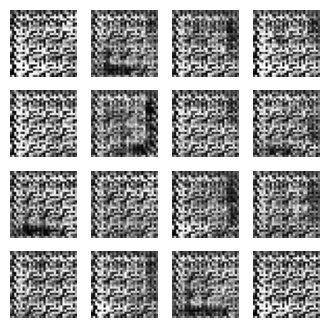

Saving checkpoint for epoch 25 at ./training_checkpoints/ckpt-25


In [29]:
for epoch in range(1, EPOCHS+1):
    for image_batch in train_dataset:
        train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)

    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = generator(seed, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

### Generate a GIF of Generated Images

In [30]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<ipython-input-30-19d8e987e05b>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-30-19d8e987e05b>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [31]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-7a1uuf5b
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-7a1uuf5b
  Resolved https://github.com/tensorflow/docs to commit 75b2672b5bed8ca0995663536db84bd9a39b8896
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=182531 sha256=5024ec0759409221d33019e95486bf006f9faa183ee72e43e3ca866eb71d5043
  Stored in directory: /tmp/pip-ephem-wheel-cache-rsv272_s/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs



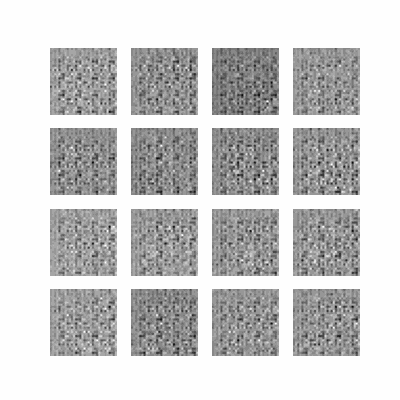

In [32]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)